# Compare DM / Dm with Nystrom extension / roseland / HKC using massive data sets

## Define functions

### import libraries

In [1]:
%pylab inline

from scipy.spatial.distance import cdist
from scipy.sparse.linalg import svds
from scipy.stats import norm
from math import ceil

#from scipy.io import savemat,loadmat
from mpl_toolkits.mplot3d import Axes3D

set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})

Populating the interactive namespace from numpy and matplotlib


### plot results

In [2]:
def plotdata(DATA):
    cmap = cm.jet    
    fig  = plt.figure(figsize=(len(DATA)*6.8, 6))
    
    j = 1
    for i in DATA.keys():
        ax = fig.add_subplot(1,len(DATA),j)
        col = cmap(linspace(0,1,len(DATA[i])))
        ax.scatter(DATA[i][:,0],DATA[i][:,1], color=col,s=2)
        ax.set_title(i)
        j += 1
    plt.show()

In [3]:
def plotemb(EMB,exetime):
    cmap = cm.jet
    col  = cmap(linspace(0,1,n))
    
    fig = plt.figure(figsize=(len(EMB)*6.8, 6))
    
    j = 1
    for i in EMB.keys():
        ax = fig.add_subplot(1,len(EMB),j)
        ax.scatter(EMB[i][:,1],EMB[i][:,2], color=col,s=2)
        print(i,'execution time: ','%.4f'%exetime[i],'s\n')
        ax.set_title(i)
        j += 1
    plt.show()

In [4]:
def ploteig(EIG):
    cmap = cm.jet
    col = cmap(linspace(0,1,len(EIG)))
    
    dim = len(next(iter(EIG.values())))
    
    j = 0
    print('eigenvalue:')
    for i in EIG.keys():
        plot(range(dim), EIG[i], color=col[j], marker='.', markersize=10, label=i)
        print(EIG[i], i)
        j += 1
        
    plt.gcf().set_size_inches(6,6)
    plt.title('eigenvalues')
    plt.legend()
    plt.show()

### generate data

In [5]:
def distribution(n,q):
    if q==0:
        Q = arange(n)/n
    else:        
        Q = []
        m = int(ceil(n/q))
        scale = 0.02
        tmp = linspace(scale,1-scale,m)
        tmp = norm.ppf(tmp)
        tmp = (tmp-min(tmp))/(max(tmp)-min(tmp))
        
        for j in range(q):            
            Q.extend(tmp+0.9*j)
            
        Q = (sort(array(Q))-min(Q))/(max(Q)-min(Q))
        Q = Q[:n]
        
    return Q.reshape(n,1)

In [6]:
def circle(Q):

    Q *= 2*pi
    
    return hstack((cos(Q),sin(Q)))

In [7]:
def knot(Q):
    
    # x = sin(Q)+2*sin(2*Q)
    # y = cos(Q)-2*cos(2*Q)
    # z = 2*sin(3*Q)
    
    Q *= 2*pi
    
    x = sin(Q)+2*sin(2*Q)
    y = cos(Q)-2*cos(2*Q)
    z = -sin(3*Q)
    
    return hstack((x,y,z))

In [8]:
def landmark1(X,m):
    sample = arange(n)[::ceil(n/m)][:m]
    Y      = X[sample]
    
    return Y, sample

### diffusion maps / DM with Nystrom extension / roseland / HKC

In [9]:
def MK(X,Y,sigma):
    
    dist = cdist(X,Y)

    return exp(-dist**2/sigma)

In [10]:
def DM(X,sigma,dim=6):
    t = time.time()
    n = X.shape[0]
    
    K = MK(X,X,sigma)
    Q = vstack((arange(n), sum(K,axis=1))).T
    D = diag(1/sqrt(sum(K,axis=1)))
    A = D.dot(K).dot(D)
    
    U,S,V = svds(A,dim)
    
    S = S[::-1]
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
    
    exetime = time.time()-t
    
    return emb, exetime, Q

In [11]:
def roseland(X,Y,sigma,dim=6):
    t = time.time()
    n = X.shape[0]

    K = MK(X,Y,sigma)    
    tmp1 = sum(K, axis=0)
    tmp2 = K.dot(tmp1)
    D    = diag(1/sqrt(tmp2))
    A    = D.dot(K)

    U,S,V = svds(A,dim)
    
    S = S[::-1]**2
    U = U[:,::-1]
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
                        
    emb = D.dot(U).dot(diag(S))
    
    exetime = time.time()-t
    
    return emb, exetime

In [12]:
def nystrom(X,Y,sample,sigma,dim=6):
    t = time.time()
    n = X.shape[0]
    
    ind1 = sample
    ind2 = delete(arange(n),ind1)
    ind = hstack((ind1,ind2))

    K = MK(X,Y,sigma) 
    K = K[ind]
    D = diag(1/sqrt(sum(K,axis=1)))
    Dsm = diag(1/sqrt(sum(K,axis=0)))

    Q = D.dot(K).dot(Dsm)
    A = Q[:m]
    B = Q[m:]
    
    uu,ss,vv = svd(A)
    AA = uu.dot(diag(1/sqrt(ss))).dot(vv)
        
    SS = A + AA.dot(B.T).dot(B).dot(AA)
        
    U,S,VV = svds(SS,dim)
    
    S = S[::-1]
    U = U[:,::-1]*sqrt(n)
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
    
    V = Q.dot(AA).dot(U).dot(diag(1/sqrt(S)))

    emb = D.dot(V).dot(diag(S))

    emb2 = zeros((n,dim))
    emb2[ind1] = emb[:m]
    emb2[ind2] = emb[m:]
    
    exetime = time.time()-t

    return emb2, exetime

In [13]:
def HKC(X,Y,sigma,dim=6):
    t = time.time()
        
    K = MK(X,Y,sigma)
    D = diag(1/sum(K,axis=1))
    A = D.dot(K)
    AA = (A.transpose()).dot(A)
    
    U,S,V = svds(AA,dim)
    
    S = S[::-1]
    U = U[:,::-1]*sqrt(n)
    
    for i in range(dim):
        if U[0,i]<0:
            U[:,i] = -U[:,i]
        
    emb = A.dot(U).dot(diag(1/sqrt(S)))

    exetime = time.time()-t
    
    return emb, exetime

In [14]:
def test(X,Y,sample,sigma):
    EMB = {}
    exetime = {}
    
    EMB['DM'],      exetime['DM'], Q    = DM(X,sigma[0])
    EMB['roseland'],exetime['roseland'] = roseland(X,Y,sigma[1])
    EMB['Nystrom'], exetime['Nystrom']  = nystrom(X,Y,sample,sigma[2])
    EMB['HKC'],     exetime['HKC']      = HKC(X,Y,sigma[3])
    
    return EMB, exetime, Q

## data set 1 (uniform distribution) with 50 landmarks

In [15]:
n = 2000
m = 50

sigma = [0.1]*4

print('data set size:',n,'\nlandmark set size: ',m)

data set size: 2000 
landmark set size:  50


In [16]:
Q = distribution(n,0)

X1 = circle(Q)

sample1 = arange(n)[::ceil(n/m)][:m]
Y1 = X1[sample1]

In [17]:
DATA1 = {}
DATA1['data set'] = X1
DATA1['landmark set'] = Y1

EMB1,exetime1, DATA1['density'] = test(X1,Y1,sample1,sigma)

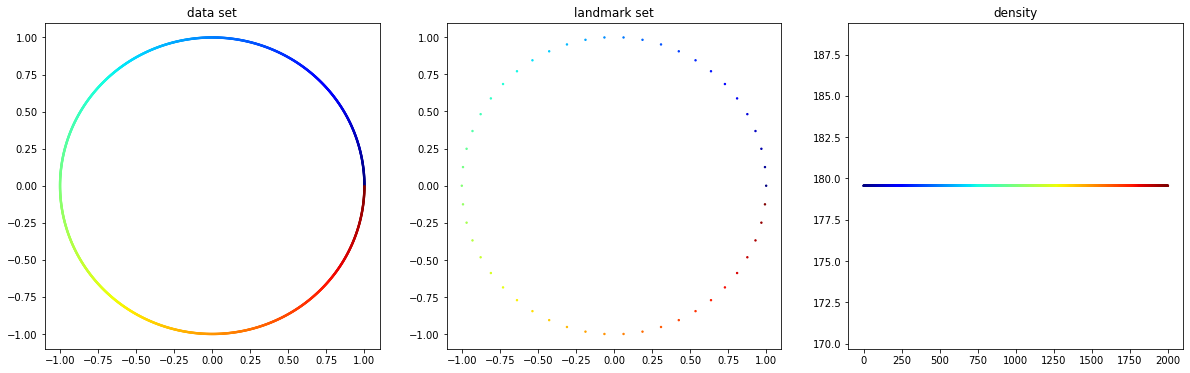

DM execution time:  0.5923 s

roseland execution time:  0.0244 s

Nystrom execution time:  0.0266 s

HKC execution time:  0.0146 s



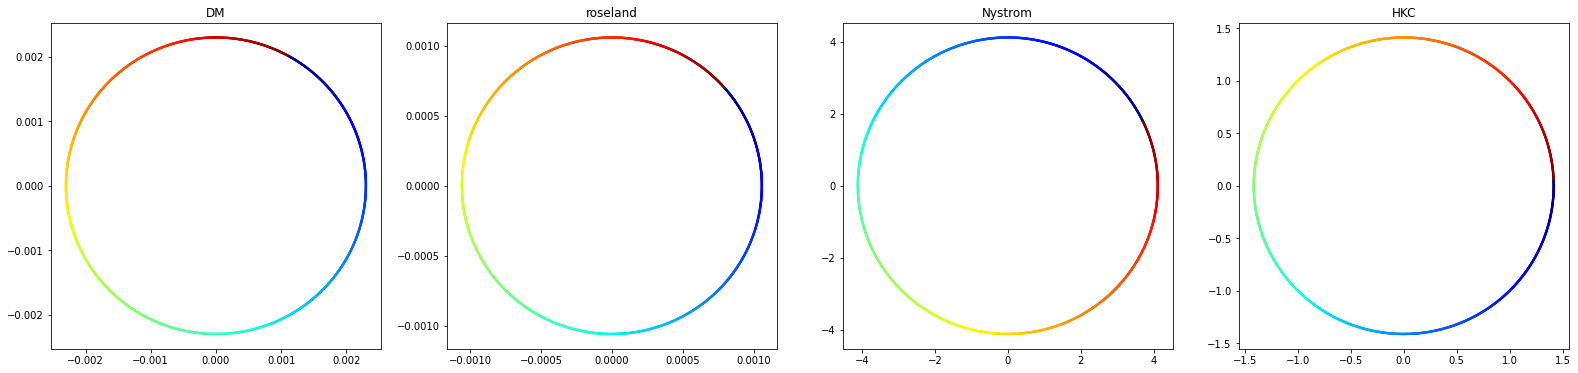

In [18]:
plotdata(DATA1)
plotemb(EMB1,exetime1)

## data set 2 (nonuniform distribution) with 50 landmarks

In [19]:
n = 2000
m = 50

sigma = [0.1,0.1,0.2,0.5]

print('data set size:',n,'\nlandmark set size: ',m)

data set size: 2000 
landmark set size:  50


In [20]:
Q = distribution(n,3)

X2 = circle(Q)

sample2 = arange(n)[::ceil(n/m)][:m]
Y2 = X2[sample2]

In [21]:
DATA2 = {}
DATA2['data set'] = X2
DATA2['landmark set'] = Y2

EMB2,exetime2, DATA2['density'] = test(X2,Y2,sample2,sigma)

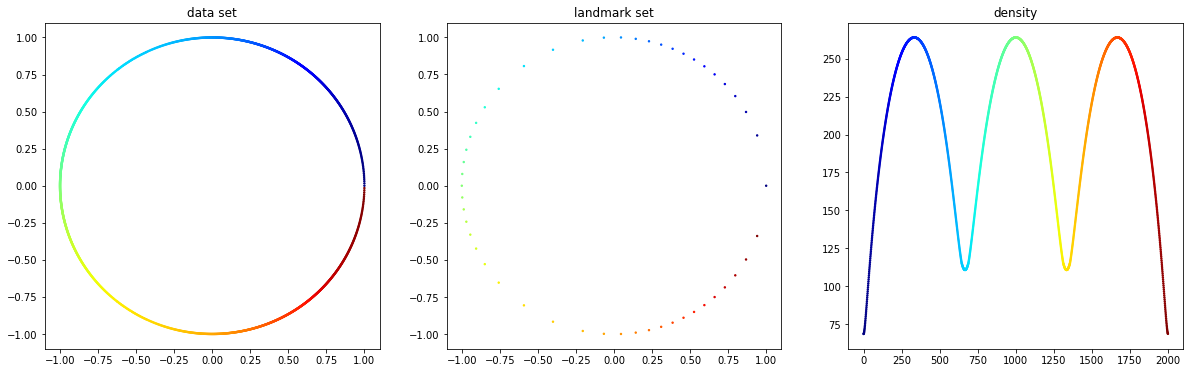

DM execution time:  0.5590 s

roseland execution time:  0.0264 s

Nystrom execution time:  0.0223 s

HKC execution time:  0.0144 s



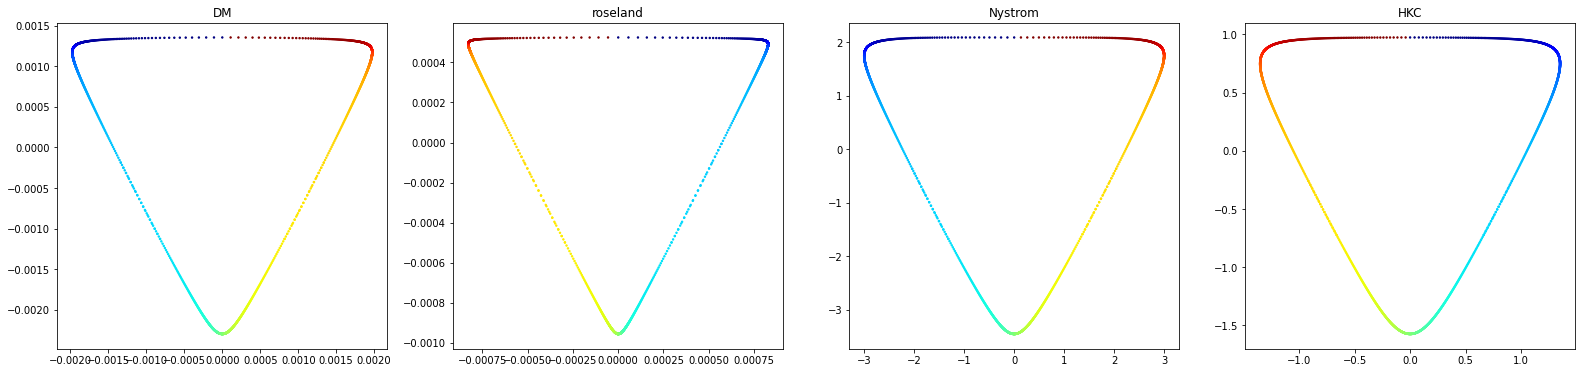

In [22]:
plotdata(DATA2)
plotemb(EMB2,exetime2)

## data set 3 (nonuniform distribution) with 50 landmarks

In [23]:
n = 2000
m = 50

sigma = [0.1,0.1,0.3,0.1]

print('data set size:',n,'\nlandmark set size: ',m)

data set size: 2000 
landmark set size:  50


In [24]:
Q = distribution(n,0)

X3 = knot(Q)

sample3 = arange(n)[::ceil(n/m)][:m]
Y3 = X3[sample3]

In [25]:
DATA3 = {}
DATA3['data set'] = X3
DATA3['landmark set'] = Y3

EMB3,exetime3,DATA3['density'] = test(X3,Y3,sample3,sigma)

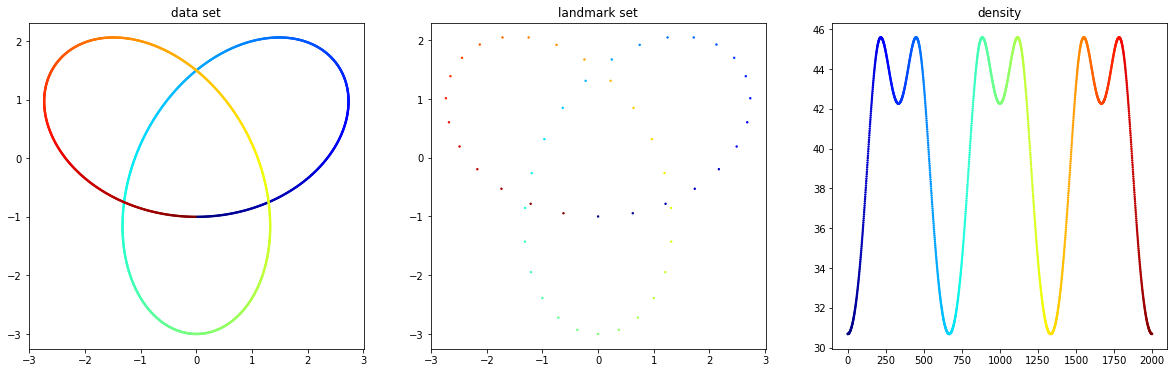

DM execution time:  0.9939 s

roseland execution time:  0.0355 s

Nystrom execution time:  0.0260 s

HKC execution time:  0.0191 s



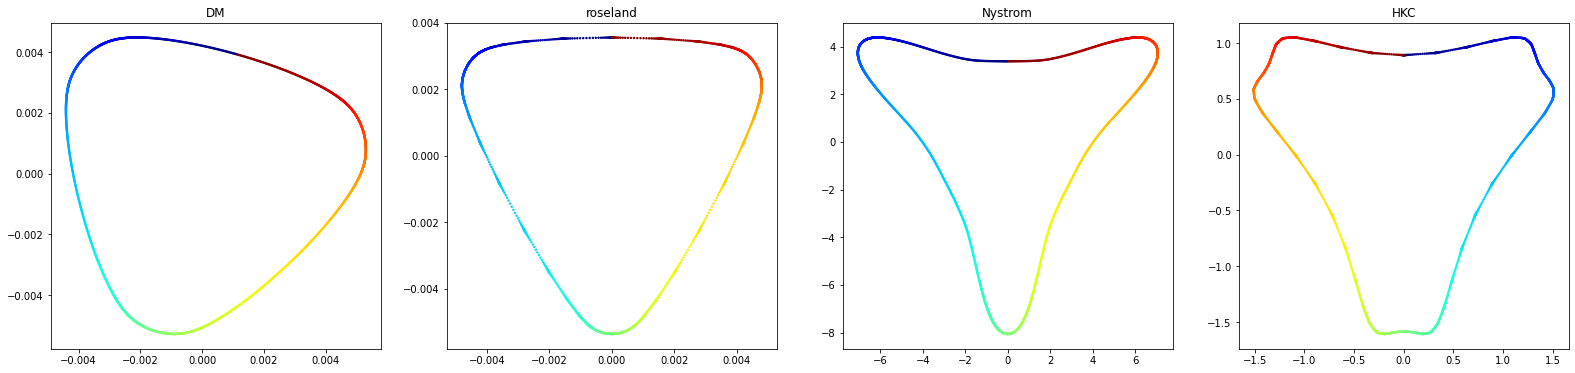

In [26]:
plotdata(DATA3)
plotemb(EMB3,exetime3)

## data set 3 (nonuniform distribution) with 100 landmarks

In [27]:
n = 2000
m = 100

sigma = [0.1,0.1,0.1,0.1]

print('data set size:',n,'\nlandmark set size: ',m)

data set size: 2000 
landmark set size:  100


In [28]:
sample4 = arange(n)[::ceil(n/m)][:m]
Y4 = X3[sample4]

In [29]:
DATA4 = {}
DATA4['data set'] = X3
DATA4['landmark set'] = Y4

EMB4,exetime4,DATA4['density'] = test(X3,Y4,sample4,sigma)

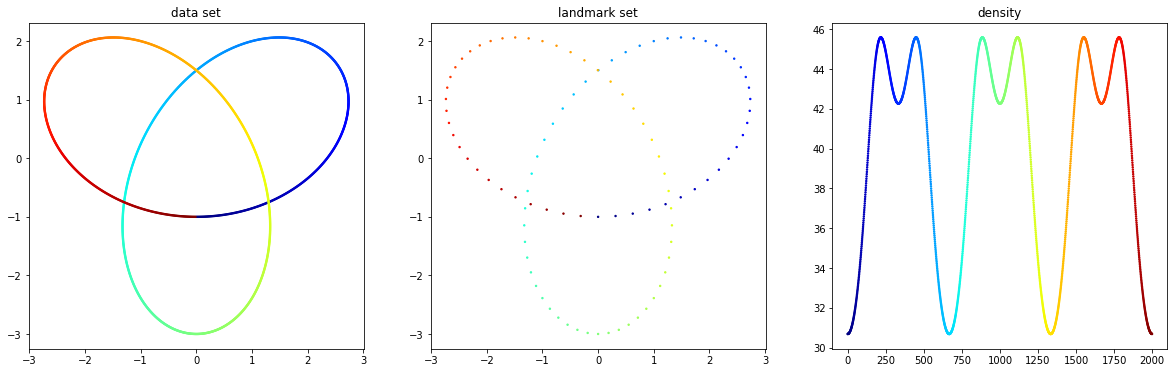

DM execution time:  1.0114 s

roseland execution time:  0.0571 s

Nystrom execution time:  0.0737 s

HKC execution time:  0.0427 s



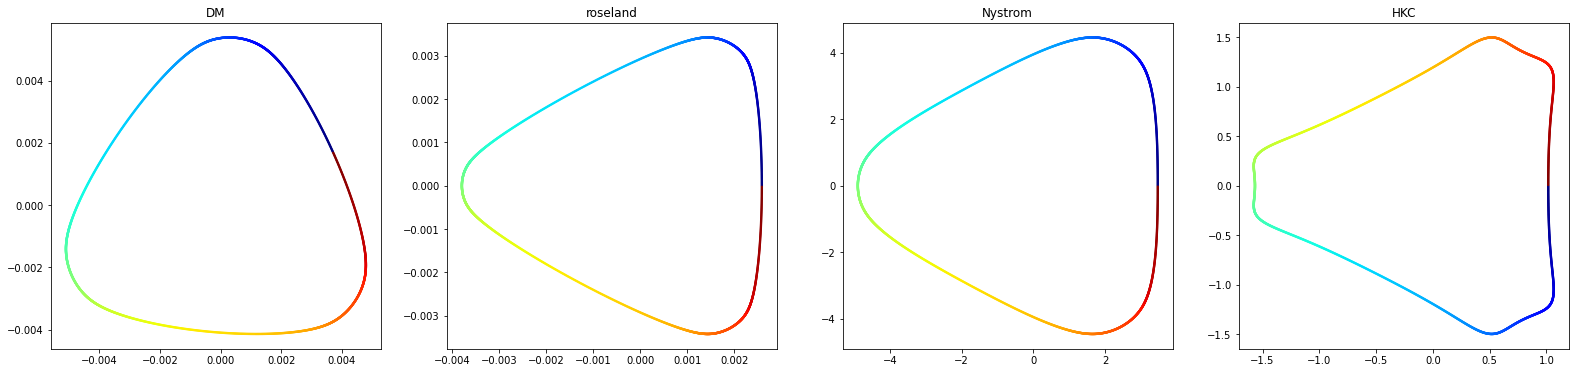

In [30]:
plotdata(DATA4)
plotemb(EMB4,exetime4)